In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
 # convert to one-hot-encoding
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt

## Load in the Dataset

In [2]:
X_train = np.load("256_192_train.npy")

In [4]:
y_train = np.load("train_labels.npy")

In [5]:
X_val = np.load("256_192_val.npy")

In [6]:
y_val = np.load("val_labels.npy")

In [7]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

In [8]:
y_train.shape, y_val.shape

((8111,), (902,))

In [9]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [10]:
y_train.shape, y_val.shape

((8111, 7), (902, 7))

## Load Pretrained Model

In [11]:
pre_trained_model = InceptionResNetV2(input_shape=(192, 256, 3), include_top=False, weights="imagenet")



219055592/219055592 [==============================] - 457s 2us/step


In [12]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed_5b
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
conv2d_12
conv2d_14
conv2d_17
batch_normalization_12
batch_normalization_14
batch_normalization_17
activation_12
activation_14
activation_17
block35_1_mixed
block35_1_conv
custom_scale_layer
block35_1_ac
conv2d_21
batch_normalization_21
activation_21
conv2d_19
conv2

In [13]:
last_layer = pre_trained_model.get_layer('conv_7b_ac')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 6, 1536)


## Define the Model

In [14]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)


In [15]:
# Configure and compile the model
import tensorflow.keras as keras
model.compile(optimizer='Adam' , loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 95, 127, 32)          864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 95, 127, 32)          96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 95, 127, 32)          0         ['batch_normalization[0][0

## Training

### Feature Extraction

In [17]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [18]:
batch_size = 64
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

C:\Users\janar\AppData\Local\Temp\ipykernel_11372\3971016608.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/3


126/126 [==============================] - 888s 7s/step - loss: 1.4203 - accuracy: 0.6379 - val_loss: 2.0430 - val_accuracy: 0.6853
Epoch 2/3
126/126 [==============================] - 840s 7s/step - loss: 0.9843 - accuracy: 0.6824 - val_loss: 0.9609 - val_accuracy: 0.6830
Epoch 3/3
126/126 [==============================] - 915s 7s/step - loss: 0.9411 - accuracy: 0.6791 - val_loss: 0.8719 - val_accuracy: 0.7031


### Fine Tuning

In [19]:
pre_trained_model.layers[617].name

'mixed_7a'

In [20]:
for layer in pre_trained_model.layers[618:]:
    layer.trainable = True

In [21]:
model.compile(optimizer='Adam' , loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])

In [22]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1, factor=0.5, min_lr=0.00001,cooldown=2)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 95, 127, 32)          864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 95, 127, 32)          96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 95, 127, 32)          0         ['batch_normalization[0][0

In [24]:
batch_size = 64
epochs = 25
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

C:\Users\janar\AppData\Local\Temp\ipykernel_11372\1600363926.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/25
126/126 [==============================] - 1013s 8s/step - loss: 0.8902 - accuracy: 0.6994 - val_loss: 5.6131 - val_accuracy: 0.6518 - lr: 0.0010
Epoch 2/25
126/126 [==============================] - 877s 7s/step - loss: 0.7563 - accuracy: 0.7291 - val_loss: 0.8109 - val_accuracy: 0.7277 - lr: 0.0010
Epoch 3/25
126/126 [==============================] - 889s 7s/step - loss: 0.6906 - accuracy: 0.7534 - val_loss: 0.8513 - val_accuracy: 0.6607 - lr: 0.0010
Epoch 4/25
126/126 [==============================] - 902s 7s/step - loss: 0.6332 - accuracy: 0.7682 - val_loss: 0.6535 - val_accuracy: 0.7478 - lr: 0.0010
Epoch 5/25
126/126 [==============================] - 975s 8s/step - loss: 0.6058 - accuracy: 0.7868 - val_loss: 0.7603 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 6/25
126/126 [==============================] - 928s 7s/step - loss: 0.5936 - accuracy: 0.7917 - val_loss: 0.8544 - val_accuracy: 0.7299 - lr: 0.0010
Epoch 7/25
126/126 [==============================] - 918s 7s/s

In [25]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001,cooldown=1)

In [26]:
 model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                     epochs = 5, validation_data = val_datagen.flow(X_val, y_val),
                     verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                     validation_steps=(X_val.shape[0] // batch_size),
                     callbacks=[learning_rate_reduction])

C:\Users\janar\AppData\Local\Temp\ipykernel_11372\1915657347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/5
126/126 [==============================] - 919s 7s/step - loss: 0.2079 - accuracy: 0.9288 - val_loss: 0.6779 - val_accuracy: 0.8348 - lr: 2.5000e-04
Epoch 2/5
126/126 [==============================] - 944s 7s/step - loss: 0.1941 - accuracy: 0.9344 - val_loss: 0.5774 - val_accuracy: 0.8527 - lr: 2.5000e-04
Epoch 3/5
126/126 [==============================] - 937s 7s/step - loss: 0.1870 - accuracy: 0.9336 - val_loss: 0.7032 - val_accuracy: 0.8438 - lr: 2.5000e-04
Epoch 4/5
126/126 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9422
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
126/126 [==============================] - 952s 8s/step - loss: 0.1699 - accuracy: 0.9422 - val_loss: 0.8191 - val_accuracy: 0.8281 - lr: 2.5000e-04
Epoch 5/5
126/126 [==============================] - 983s 8s/step - loss: 0.1743 - accuracy: 0.9387 - val_loss: 0.8930 - val_accuracy: 0.8036 - lr: 1.2500e-04


In [27]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 37s 1s/step - loss: 0.8022 - accuracy: 0.8304
Validation: accuracy = 0.830377  ;  loss_v = 0.802225


## Testing

In [28]:
X_test = np.load("256_192_test.npy")

In [29]:
y_test = np.load("test_labels.npy")
y_test = to_categorical(y_test)

In [30]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 42s 1s/step - loss: 0.8263 - accuracy: 0.8253
Test: accuracy = 0.825349  ;  loss = 0.826344


In [31]:
model.save("InceptionResNet.h5")

C:\Users\janar\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

29/29 [==============================] - 42s 1s/step
Classification report for classifier <keras.src.engine.functional.Functional object at 0x000001FA34F82710>:
              precision    recall  f1-score   support

     class 0       0.76      0.48      0.59        33
     class 1       1.00      0.49      0.66        51
     class 2       0.64      0.68      0.66        96
     class 3       0.57      0.44      0.50         9
     class 4       0.87      0.97      0.92       600
     class 5       0.92      0.79      0.85        14
     class 6       0.69      0.48      0.57        99

    accuracy                           0.83       902
   macro avg       0.78      0.62      0.68       902
weighted avg       0.83      0.83      0.82       902




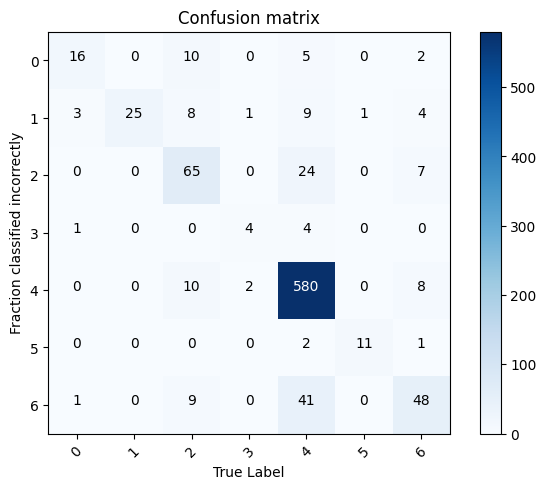

In [33]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

      #classes = {
 #0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
 #1: ('bcc', 'basal cell carcinoma'),
 #2: ('bkl', 'benign keratosis-like lesions'),
 #3: ('df', 'dermatofibroma'),
 #4: ('nv', 'melanocytic nevi'),
 #5: ('vasc', 'pyogenic granulomas and hemorrhage'),
 #6: ('mel', 'melanoma')}

Text(0.5, 1.0, 'Training and validation loss')

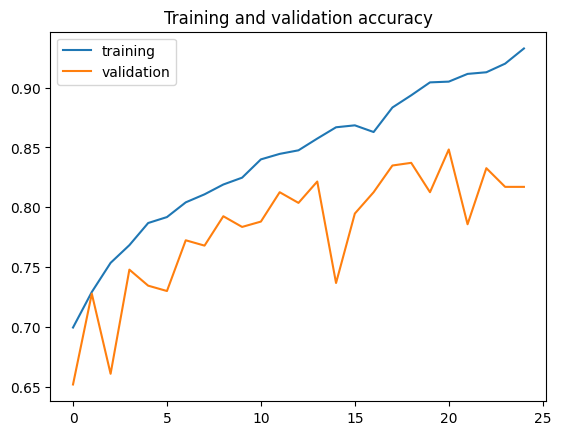

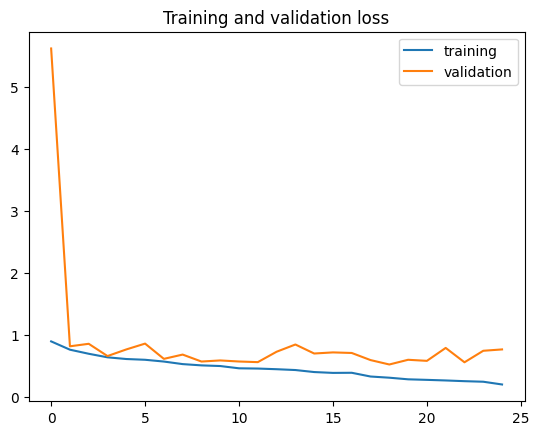

In [34]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')